<div class="alert alert-info">
<h1> <b>Key Results</b> </h1>
<br>
Takes in results of Monte Carlo simulations and generates key results used in the paper. <br>
Quotes are provided to give context for how results are used in the final publication
</div>

<div class="alert alert-info">
<b>Table of Contents</b> <br><br>
1. <a href="#choropleths">Data for Choropleths</a> <br>
2. <a href="#overall">Overall Access Numbers</a> <br>
3. <a href="#cycling_walking">Cycling vs Walking</a> <br>
4. <a href="#piped">Relationship between piped access and GCIL water access</a>
</div>

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import weightedstats as ws
from tabulate import tabulate
from scipy.stats import spearmanr

In [2]:
# Read country-level results from Monte Carlo sims
country_medians = pd.read_csv("../results/country_median_results.csv")
country_means = pd.read_csv("../results/country_mean_results.csv")
country_5th_percentiles = pd.read_csv("../results/country_5th_percentile_results.csv")
country_95th_percentiles = pd.read_csv("../results/country_95th_percentile_results.csv")

# Read district-level results from Monte Carlo sims
district_medians = pd.read_csv("../results/districts_median_results.csv")
district_means = pd.read_csv("../results/districts_mean_results.csv")
district_5th_percentiles = pd.read_csv("../results/districts_5th_percentile_results.csv")
district_95th_percentiles = pd.read_csv("../results/districts_95th_percentile_results.csv")


# Drop global from all dataframes
country_medians = country_medians[country_medians["ISOCODE"] != "GLOBAL"]
country_means = country_means[country_means["ISOCODE"] != "GLOBAL"]
country_5th_percentiles = country_5th_percentiles[country_5th_percentiles["ISOCODE"] != "GLOBAL"]
country_95th_percentiles = country_95th_percentiles[country_95th_percentiles["ISOCODE"] != "GLOBAL"]
# No need to drop from district-level dataframes as they don't have a global entry


In [3]:
# Constants to save new results (will overwrite existing results)
SAVE_CSVS = False
SAVE_FIGURES = False

<div class="alert alert-info">
<h3> <b>1. Data for Choropleths </b> </h3>
<a id="choropleths"></a>
Simplified data to export to Datawrapper for making maps of water access loss in GCIL.
</div>

In [4]:
country_medians_simple = country_medians[["ISOCODE", "Entity", "percent_without_water"]]
venezuela_medians = district_medians[district_medians["Entity"] == "Venezuela"]
venezuela_medians_simple = venezuela_medians[["shapeName", "percent_without_water"]]

if SAVE_CSVS == True:
    country_medians_simple.to_csv("../results/country_medians_simple.csv", index=False)
    country_medians_simple.to_csv("../results/venezulea_means_simple.csv", index=False)

<div class="alert alert-info">
<h3> <b>2. Overall Access Numbers </b> </h3>
<a id="overall"></a>
Overall access (walking and cycling) for the world, and select countries
</div>

In [5]:
#add required extras
country_means["percent_piped_with_access"] = country_means["population_piped_with_access"] / country_means["country_pop_raw"] * 100
country_means["piped_calculated"] = country_means["percent_without_water"] + country_means["percent_piped_with_access"]

# Add required extras for 5th percentiles
country_5th_percentiles["percent_piped_with_access"] = country_5th_percentiles["population_piped_with_access"] / country_5th_percentiles["country_pop_raw"] * 100
country_5th_percentiles["piped_calculated"] = country_5th_percentiles["percent_without_water"] + country_5th_percentiles["percent_piped_with_access"]

# Add required extras for 95th percentiles
country_95th_percentiles["percent_piped_with_access"] = country_95th_percentiles["population_piped_with_access"] / country_95th_percentiles["country_pop_raw"] * 100
country_95th_percentiles["piped_calculated"] = country_95th_percentiles["percent_without_water"] + country_95th_percentiles["percent_piped_with_access"]


country_medians["percent_piped_with_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_raw"] * 100
country_medians["piped_calculated"] = country_medians["percent_without_water"] + country_medians["percent_piped_with_access"]


<div class="alert alert-success"> Quote from paper: "Globally, the median model results indicate that <b>29% (90% CI 21–41%)</b> of the world population would be unable to access sufficient water in the aftermath of a GCIL scenario (Figure 3)."

In [6]:
# Overall global population without water
global_median_percentage_without_water = country_medians["country_pop_without_water"].sum() / country_medians["country_pop_raw"].sum()
global_5th_percentage_without_water = country_5th_percentiles["country_pop_without_water"].sum() / country_5th_percentiles["country_pop_raw"].sum()
global_95th_percentage_without_water = country_95th_percentiles["country_pop_without_water"].sum() / country_95th_percentiles["country_pop_raw"].sum()

global_median_percentage_with_water = country_medians["country_pop_with_water"].sum() / country_medians["country_pop_raw"].sum()

# Print overall results
print(f"Global median percentage without water: {global_median_percentage_without_water}")
print(f"Global 5th percentile percentage without water: {global_5th_percentage_without_water}")
print(f"Global 95th percentile percentage without water: {global_95th_percentage_without_water}")

# sense check with percentage with water
print("")
print(f"Global median percentage with water: {global_median_percentage_with_water}")
print("")

Global median percentage without water: 0.2292848581237949
Global 5th percentile percentage without water: 0.14284144912791183
Global 95th percentile percentage without water: 0.3318259475291271

Global median percentage with water: 0.7705763048908014



<div class="alert alert-success"> Quote from paper: "Of the <b>71%</b> with water access, <b>56% (90% CI 48–60%)</b> usually rely on piped water and would therefore have to walk or cycle to a freshwater source, while the remainder would, in theory, continue to use their non-piped sources."

In [7]:
# Piped populations without water
proportion_with_water_piped_median = country_medians["population_piped_with_access"].sum() / country_medians["country_pop_with_water"].sum()
proportion_with_water_piped_5th = country_5th_percentiles["population_piped_with_access"].sum() / country_5th_percentiles["country_pop_with_water"].sum()
proportion_with_water_piped_95th = country_95th_percentiles["population_piped_with_access"].sum() / country_95th_percentiles["country_pop_with_water"].sum()

# Print piped results
# sense check with percentage with water
print(f"Global median percentage with water: {global_median_percentage_with_water}")
print(f"Median proportion with water access who are piped: {proportion_with_water_piped_median}")
print(f"5th percentile proportion with water access who are piped: {proportion_with_water_piped_5th}")
print(f"95th percentile proportion with water access who are piped: {proportion_with_water_piped_95th}")

Global median percentage with water: 0.7705763048908014
Median proportion with water access who are piped: 0.5380600530528451
5th percentile proportion with water access who are piped: 0.46715387280697296
95th percentile proportion with water access who are piped: 0.5846536880865069


<div class="alert alert-success"> Quote from paper: "The regional percentage of people without water access was highest in Africa at <b>44.1% (90% CI 39.6–49.9%)</b>, followed by the Americas at <b>41.4% (90% CI 28.9–58.8)</b>, Oceania at <b>32.4% (90% 26.3–44.1)</b>, Europe at <b>25.9% (90% CI 14.1–47.2)</b>, and Asia at <b>22.5% (90% CI 15.7–32.9)</b>."

In [8]:
# Define a function to calculate percent without water
def calculate_percent(df, group):
    data = df.groupby(group).sum()
    percent_without_water = (data['country_pop_without_water'] / data['country_pop_raw']) * 100
    return percent_without_water

# Calculate percent without water for each DataFrame
region_percent_without_water_median = calculate_percent(country_medians, "region")
region_percent_without_water_5th = calculate_percent(country_5th_percentiles, "region")
region_percent_without_water_95th = calculate_percent(country_95th_percentiles, "region")

# Merge results into a single DataFrame
region_percent_without_water = pd.DataFrame({
    'median': region_percent_without_water_median,
    '5th_percentile': region_percent_without_water_5th,
    '95th_percentile': region_percent_without_water_95th
})

# Repeat for subregions
subregion_percent_without_water_median = calculate_percent(country_medians, "subregion")
subregion_percent_without_water_5th = calculate_percent(country_medians, "subregion")
subregion_percent_without_water_95th = calculate_percent(country_medians, "subregion")

# Merge results into a single DataFrame
subregion_percent_without_water = pd.DataFrame({
    'median': subregion_percent_without_water_median,
    '5th_percentile': subregion_percent_without_water_5th,
    '95th_percentile': subregion_percent_without_water_95th
})

# Define formatting function
def format_results(row):
    median = round(row['median'], 1)
    p5th = round(row['5th_percentile'], 1)
    p95th = round(row['95th_percentile'], 1)
    return f"{median} ({p5th}–{p95th})"

# Apply formatting function to each row
region_percent_without_water['formatted_results'] = region_percent_without_water.apply(format_results, axis=1)
subregion_percent_without_water['formatted_results'] = subregion_percent_without_water.apply(format_results, axis=1)

# Print results
print(region_percent_without_water.sort_values(by='median', ascending=False))
print(subregion_percent_without_water.sort_values(by='median', ascending=False))

region_percent_without_water.to_csv("../results/region_results.csv", index=True)
subregion_percent_without_water.to_csv("../results/subregion_results.csv", index=True)

             median  5th_percentile  95th_percentile formatted_results
region                                                                
Americas  36.666757       24.485413        50.360961  36.7 (24.5–50.4)
Europe    23.061363       10.941837        38.306181  23.1 (10.9–38.3)
Africa    22.288981       15.517477        29.501465  22.3 (15.5–29.5)
Asia      20.120619       12.260690        29.691903  20.1 (12.3–29.7)
Oceania   17.525905        8.916453        30.022932   17.5 (8.9–30.0)
                                    median  5th_percentile  95th_percentile  \
subregion                                                                     
Polynesia                        66.882198       66.882198        66.882198   
Western Asia                     53.312044       53.312044        53.312044   
Northern Africa                  44.549014       44.549014        44.549014   
Latin America and the Caribbean  39.630450       39.630450        39.630450   
Northern America             

<div class="alert alert-success">Quote from paper: All five of the worst ranked countries were in the Arabian Peninsula, led by the United Arab Emirates (UAE) with 99.97%

In [9]:
# Make a single table with the 10 countries with the highest and lowest percentage of people without access to water
top10 = country_medians_simple.nlargest(10, "percent_without_water")
bottom10 = country_medians_simple.nsmallest(10, "percent_without_water")
top_bottom = pd.concat([top10, bottom10])

if SAVE_CSVS == True:
    top_bottom.to_csv("../results/top_bottom_10_countries.csv", index=False)

<div class="alert alert-success">Supplementary: Plot of Monte Carlo distribution

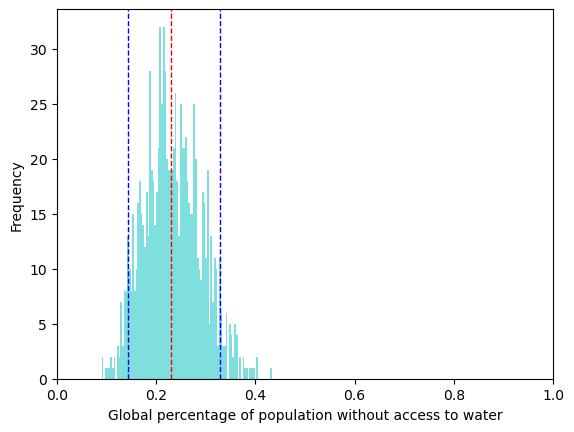

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")




# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]




# Calculate global median percentage without water for each simulation using list comprehension
global_access = [df["country_pop_without_water"].sum() / df["country_pop_raw"].sum() for df in simulation_results]

# Calculate median, 5th percentile, and 95th percentile
median = np.median(global_access)
p5 = np.percentile(global_access, 5)
p95 = np.percentile(global_access, 95)

# Plot histogram of results
fig, ax = plt.subplots()
ax.hist(global_access, bins=100, alpha=0.5, color='c')
ax.set_xlabel("Global percentage of population without access to water")
ax.set_ylabel("Frequency")
# ax.set_title("Distribution of Monte Carlo simulation results")

# Add vertical lines for median, 5th percentile, and 95th percentile
ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

# Set x-axis limits
ax.set_xlim(0, 1)

if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_no_water.png")
plt.show()

In [13]:
country_medians["percent_piped_with_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_raw"] * 100
country_medians["piped_calculated"] = country_medians["percent_without_water"] + country_medians["percent_piped_with_access"]


<div class="alert alert-info">
<h3> <b>3. Cycling vs walking results </b> </h3>
<a id="cycling_walking"></a>
</div>

<div class="alert alert-success">Quote from paper: The maximum euclidean distance people could walk one-way to water varied between <b>3.6–4.0 km</b> in the model, approximately equal to travelling 4.8–5.4 km on roads if using a conversion factor of 1.345 (Gonçalves et al., 2014). For cycling, the equivalent euclidean distances were <b>0–17.7 km</b>, equivalent to approximately 0–23.8 km on roads. <br><br> NB: These are currently given as full ranges rather than 90% CIs, as the data is not population-weighted.<br> NB: The minimum cycling distance is negative, but expressed as zero in the paper. This is due to the parameters in some regions having very poor cycling conditions (e.g., very steep, no roads), leading to the model requiring more energy than available to move forwards.


In [14]:
# @JAMES to ehlp figure out, something to do with cycling changes
# min_walking = country_medians["min_max_distance_walking"].min()
# max_walking = country_medians["max_max_distance_walking"].max()
# min_cycling = country_medians["min_max_distance_cycling"].min()
# max_cycling = country_medians["max_max_distance_cycling"].max()
# print(f"Minimum walking distance: {min_walking}")
# print(f"Maximum walking distance: {max_walking}")
# print(f"Minimum cycling distance: {min_cycling}")
# print(f"Maximum cycling distance: {max_cycling}")

<div class="alert alert-success">Quote from paper: "Bicycles increased access in the simulations, allowing <b>32% (90% CI 23–57%)</b> of the piped water population to cycle to water instead of walking. While some of these people would be close enough to walk if needed, <b>17%</b> of the piped water population, or <b>7%</b> of the total world population, would not."

In [15]:
# For walking vs cycling breakdown, we are using the mean results instead of median as this will lead to more intuitive comparisons.
# If we use the medians, the sum of the individual walking and cycling access may be very different to the the sum of the total access
# First, let's look at piped only
country_means["country_pop_piped"] = country_means["country_pop_raw"] * country_means["piped_calculated"] / 100

global_mean_percentage_piped_with_access = country_means["population_piped_with_access"].sum() / country_means["country_pop_piped"].sum()
global_mean_piped_percentage_with_cycling_access = country_means["population_piped_with_cycling_access"].sum() / country_means["country_pop_piped"].sum()
global_mean_piped_percentage_with_walking_access = country_means["population_piped_with_walking_access"].sum() / country_means["country_pop_piped"].sum()
global_mean_piped_percentage_with_only_cycling_access = (country_means["population_piped_with_access"].sum() - country_means["population_piped_with_walking_access"].sum()) / country_means["country_pop_piped"].sum()

print(f"Relative to global piped population: mean percentage piped with access: {global_mean_percentage_piped_with_access}")
print(f"Relative to global piped population: mean percentage piped with cycling access: {global_mean_piped_percentage_with_cycling_access}")
print(f"Relative to global piped population: mean percentage piped with walking access: {global_mean_piped_percentage_with_walking_access}")
print(f"Relative to global piped population: mean percentage piped with only cycling access: {global_mean_piped_percentage_with_only_cycling_access}")

Relative to global piped population: mean percentage piped with access: 0.6369466030402623
Relative to global piped population: mean percentage piped with cycling access: 0.42142906702830946
Relative to global piped population: mean percentage piped with walking access: 0.4287925791929127
Relative to global piped population: mean percentage piped with only cycling access: 0.20815402384734957


In [16]:
# Median, 5th, and 95th percentile results for piped water population
country_medians["country_pop_piped"] = country_medians["country_pop_raw"] * country_medians["NATPiped"] / 100
country_5th_percentiles["country_pop_piped"] = country_5th_percentiles["country_pop_raw"] * country_5th_percentiles["NATPiped"] / 100
country_95th_percentiles["country_pop_piped"] = country_95th_percentiles["country_pop_raw"] * country_95th_percentiles["NATPiped"] / 100



assert (country_medians["country_pop_piped"] == country_5th_percentiles["country_pop_piped"]).all()
assert (country_medians["country_pop_piped"] == country_95th_percentiles["country_pop_piped"]).all()

global_median_piped_percentage_with_cycling_access = country_medians["population_piped_with_cycling_access"].sum() / country_medians["country_pop_piped"].sum()
global_5th_piped_percentage_with_cycling_access = country_5th_percentiles["population_piped_with_cycling_access"].sum() / country_5th_percentiles["country_pop_piped"].sum()
global_95th_piped_percentage_with_cycling_access = country_95th_percentiles["population_piped_with_cycling_access"].sum() / country_95th_percentiles["country_pop_piped"].sum()

print(f"Relative to global piped population: median percentage piped with cycling access: {global_median_piped_percentage_with_cycling_access}")
print(f"Relative to global piped population: 5th percentile percentage piped with cycling access: {global_5th_piped_percentage_with_cycling_access}")
print(f"Relative to global piped population: 95th percentile percentage piped with cycling access: {global_95th_piped_percentage_with_cycling_access}")


Relative to global piped population: median percentage piped with cycling access: 0.4111525017524451
Relative to global piped population: 5th percentile percentage piped with cycling access: 0.36260138298801936
Relative to global piped population: 95th percentile percentage piped with cycling access: 0.43493250263819383


In [17]:
# Now looking at proportions of the global population (piped and non-piped)
# Note that this (country_pop_raw) is also including non-piped population who do not walk/cycle to collect water
global_mean_percentage_with_access = country_means["population_piped_with_access"].sum() / country_means["country_pop_raw"].sum()
global_mean_percentage_with_cycling_access = country_means["population_piped_with_cycling_access"].sum() / country_means["country_pop_raw"].sum()
global_mean_percentage_with_walking_access = country_means["population_piped_with_walking_access"].sum() / country_means["country_pop_raw"].sum()
global_mean_percentage_with_only_cycling_access = (country_means["population_piped_with_access"].sum() - country_means["population_piped_with_walking_access"].sum()) / country_means["country_pop_raw"].sum()

print(f"Global mean percentage with access: {global_mean_percentage_with_access}")
print(f"Global mean percentage with cycling access: {global_mean_percentage_with_cycling_access}")
print(f"Global mean percentage with walking access: {global_mean_percentage_with_walking_access}")
print(f"Global mean percentage with only cycling access: {global_mean_percentage_with_only_cycling_access}")

Global mean percentage with access: 0.4101306728708199
Global mean percentage with cycling access: 0.2713586759119852
Global mean percentage with walking access: 0.2761000501250608
Global mean percentage with only cycling access: 0.1340306227457591


#### Most important countries for bicycles

<div class="alert alert-success">Quote from paper: "Cycling provided access for 47% of Burkina Faso’s piped water population in the model. However, the actual water access gained is small for the countries listed (0.03–5% of their populations), due to few people being able to access water at all in UAE, Hong Kong, and Kuwait, and very few people having piped water infrastructure in Burkina Faso. In contrast, cycling enabled 26% of people in Luxembourg to fulfil essential water needs, along with 24% in Germany, 24% in Belgium, 23% in Finland, and 22% in Argentina."

In [18]:
# TODO Change to means so walking/cycling split makes sense?
# Calculate top 10 countries by lowest value for global_mean_piped_percentage_with_walking_access
country_medians["percentage_piped_with_walking_access"] = country_medians["population_piped_with_walking_access"] / country_medians["population_piped_with_access"] * 100
country_medians["percentage_piped_with_cycling_access"] = country_medians["population_piped_with_cycling_access"] / country_medians["population_piped_with_access"] * 100
country_medians["percentage_piped_of_total_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_with_water"] * 100
country_medians["population_piped_with_only_cycling_access"] = country_medians["population_piped_with_access"] - country_medians["population_piped_with_walking_access"]
country_medians["percentage_piped_with_only_cycling_access"] = country_medians["population_piped_with_only_cycling_access"] / country_medians["population_piped_with_access"] * 100
country_medians["percentage_total_with_only_cycling_access"] = country_medians["population_piped_with_only_cycling_access"] / country_medians["country_pop_raw"] * 100

top_piped_cycling_access = country_medians.nlargest(30, "percentage_piped_with_only_cycling_access")
print(tabulate(top_piped_cycling_access[['Entity', "percentage_piped_with_only_cycling_access", "percentage_total_with_only_cycling_access", 'percentage_piped_with_walking_access', 'percentage_piped_with_cycling_access', "percent_with_water"]], headers='keys', tablefmt='psql'))



+-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------+
|     | Entity                           |   percentage_piped_with_only_cycling_access |   percentage_total_with_only_cycling_access |   percentage_piped_with_walking_access |   percentage_piped_with_cycling_access |   percent_with_water |
|-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------|
|   3 | United Arab Emirates             |                                    100      |                                   0.0652233 |                                0       |                               100      |            0.0652233 |
| 145 | San Marino                      

In [19]:
# OR rank by total population that gain access by cycling
top_total_cycling_access = country_medians.nlargest(30, "percentage_total_with_only_cycling_access")
print(tabulate(top_total_cycling_access[['Entity', "percentage_total_with_only_cycling_access", "percentage_piped_with_only_cycling_access", 'percentage_piped_with_walking_access', 'percentage_piped_with_cycling_access', "percent_with_water"]], headers='keys', tablefmt='psql'))

+-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------+
|     | Entity                           |   percentage_total_with_only_cycling_access |   percentage_piped_with_only_cycling_access |   percentage_piped_with_walking_access |   percentage_piped_with_cycling_access |   percent_with_water |
|-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------|
| 145 | San Marino                       |                                     65.63   |                                    100      |                                 0      |                               100      |              65.63   |
|  94 | Liechtenstein                   

In [20]:
top_piped_cycling_access.columns

Index(['Unnamed: 0', 'ISOCODE', 'country_pop_raw', 'country_pop_with_water',
       'country_pop_without_water', 'population_piped_with_access',
       'population_piped_with_cycling_access',
       'population_piped_with_walking_access',
       'population_piped_with_only_cycling_access', 'NATPiped', 'weighted_med',
       'weighted_med_cycling', 'weighted_5th_cycling', 'weighted_95th_cycling',
       'weighted_med_walking', 'weighted_5th_walking', 'weighted_95th_walking',
       'percent_with_water', 'percent_without_water',
       'percent_piped_with_cycling_access',
       'percent_piped_with_walking_access',
       'proportion_piped_access_from_cycling',
       'percent_with_only_cycling_access', 'Entity', 'region', 'subregion',
       'percent_piped_with_access', 'piped_calculated', 'country_pop_piped',
       'percentage_piped_with_walking_access',
       'percentage_piped_with_cycling_access',
       'percentage_piped_of_total_access',
       'percentage_piped_with_only_cycling

<div class="alert alert-success">Supplementary: Plot of Monte Carlo distribution

In [30]:
# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")

# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]

# Check that GLOBAL is removed from the first dataframe
print("GLOBAL in first dataframe:", 'GLOBAL' in simulation_results[0].index)

# Calculate country_pop_piped for each dataframe in simulation_results
for df in simulation_results:
    df["country_pop_unpiped"] = df["country_pop_raw"] * (100-df["NATPiped"]) / 100

# Calculate global mean percentage for each access type for each simulation using list comprehension
global_access = [df["country_pop_with_water"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_cycling_access = [df["population_piped_with_cycling_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_walking_access = [df["population_piped_with_walking_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_only_cycling_access = [(df["population_piped_with_access"].sum() - df["population_piped_with_walking_access"].sum()) / df["country_pop_raw"].sum() for df in simulation_results]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten axs for easy iteration
axs = axs.flatten()

# List of access types
access_types = [global_access, global_walking_access, global_cycling_access, global_only_cycling_access]

# List of titles
titles = ["(a) Global Total Access", "(b) Global Walking Access", "(c) Global Cycling Access", "(d) Global Only Cycling Access"]

# Plot histogram of results for each access type
for i, ax in enumerate(axs):
    # Calculate median, 5th percentile, and 95th percentile
    median = np.median(access_types[i])
    p5 = np.percentile(access_types[i], 5)
    p95 = np.percentile(access_types[i], 95)

    ax.hist(access_types[i], bins=100, alpha=0.7, color='c')
    ax.set_xlim(0, 1)

    # Add vertical lines for median, 5th percentile, and 95th percentile
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

    # Set title and labels
    ax.set_title(f"{titles[i]}", fontsize=14)

# Set common x-axis label
fig.text(0.5, 0.0, 'Percentage Access', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_total_access.png")
plt.show()

GLOBAL in first dataframe: False


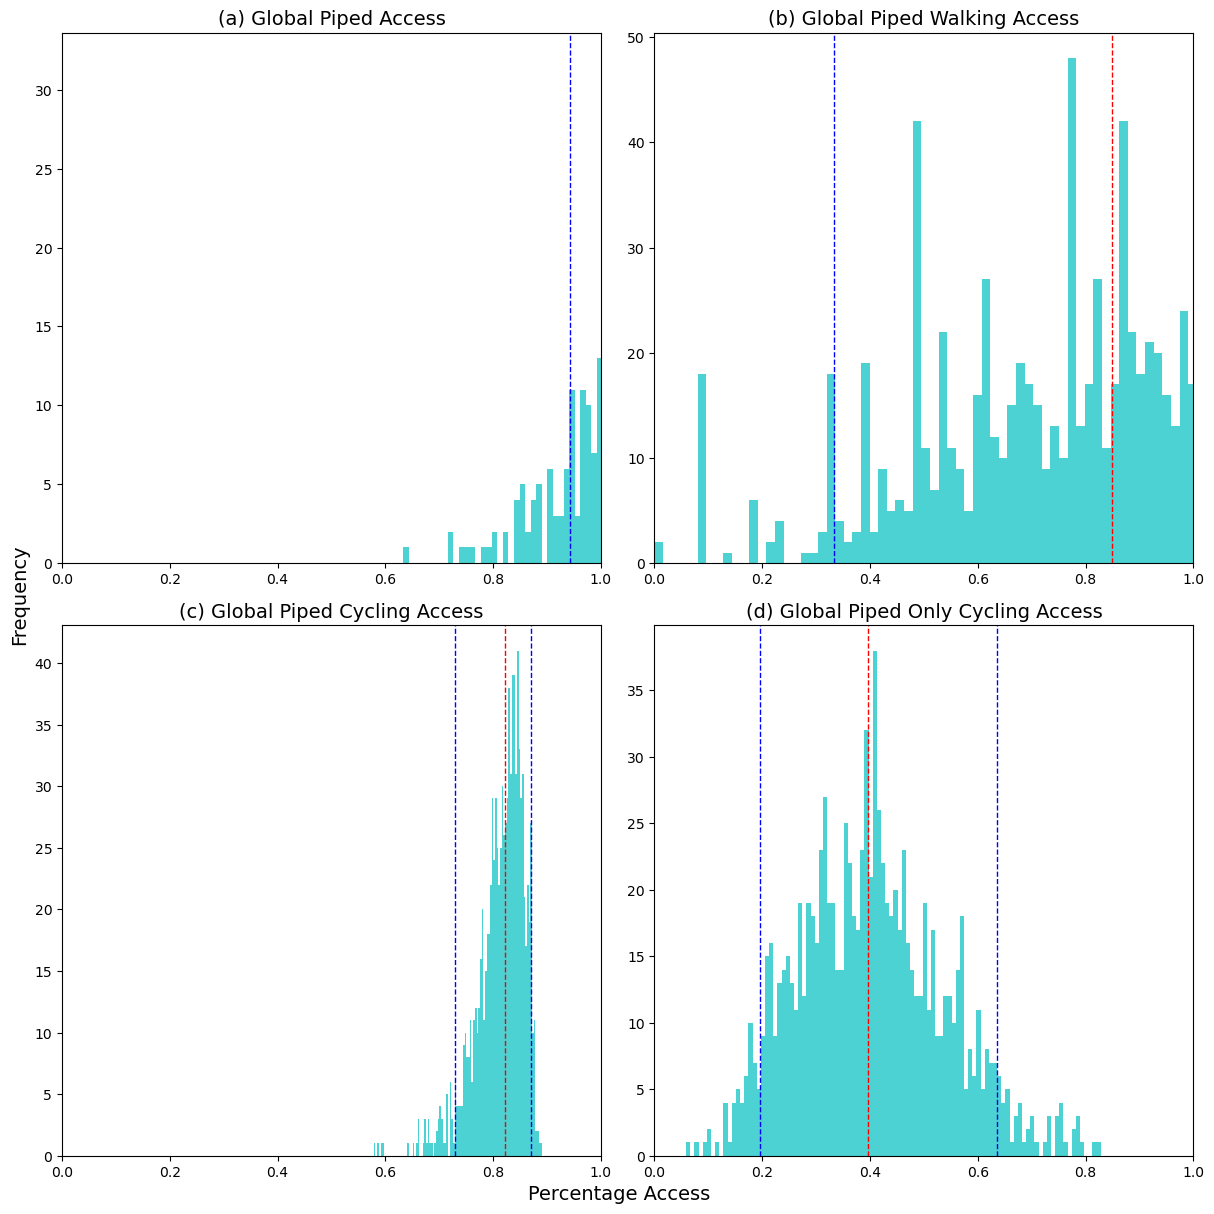

In [22]:
# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")
# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]


# Calculate country_pop_piped for each dataframe in simulation_results
for df in simulation_results:
    df["country_pop_piped"] = df["country_pop_raw"] * df["NATPiped"] / 100

# Calculate global mean percentage for each access type for each simulation using list comprehension
global_piped_access = [df["population_piped_with_access"].sum() / df["country_pop_piped"].sum() for df in simulation_results]
global_piped_cycling_access = [df["population_piped_with_cycling_access"].sum() / df["country_pop_piped"].sum() for df in simulation_results]
global_piped_walking_access = [df["population_piped_with_walking_access"].sum() / df["country_pop_piped"].sum() for df in simulation_results]
global_piped_only_cycling_access = [(df["population_piped_with_access"].sum() - df["population_piped_with_walking_access"].sum()) / df["country_pop_piped"].sum() for df in simulation_results]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten axs for easy iteration
axs = axs.flatten()

# List of access types
access_types = [global_piped_access, global_piped_walking_access, global_piped_cycling_access, global_piped_only_cycling_access]

# List of titles
titles = ["(a) Global Piped Access", "(b) Global Piped Walking Access", "(c) Global Piped Cycling Access", "(d) Global Piped Only Cycling Access"]

# Plot histogram of results for each access type
for i, ax in enumerate(axs):
    # Calculate median, 5th percentile, and 95th percentile
    median = np.median(access_types[i])
    p5 = np.percentile(access_types[i], 5)
    p95 = np.percentile(access_types[i], 95)

    ax.hist(access_types[i], bins=100, alpha=0.7, color='c')
    ax.set_xlim(0, 1)

    # Add vertical lines for median, 5th percentile, and 95th percentile
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

    # Set title and labels
    ax.set_title(f"{titles[i]}", fontsize=14)

# Set common x-axis label
fig.text(0.5, 0.0, 'Percentage Access', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_piped_access.png")
plt.show()

<div class="alert alert-info">
<h3> <b>4. Relationship between piped water access and GCIL water access </b> </h3>
<a id="piped"></a>
</div>


In [23]:
import plotly.express as px

fig = px.scatter(
    country_medians, x="NATPiped", y="piped_calculated", 
    labels={'x':'NATPiped', 'y':'Piped Calculated'}, 
    title="Piped Calculated vs NATPiped",
    # size="bubble_size",
    color="region",
    hover_data=['Entity']
).update_layout(
    width=1200,
    height=800,
).update_xaxes(
    range=[0, 105]
).update_yaxes(
    range=[0, 105]
)

fig.show()

In [24]:
correlation_piped = spearmanr(country_medians["NATPiped"], country_medians["piped_calculated"])
correlation_piped


SignificanceResult(statistic=0.9686810653513711, pvalue=1.2537460795052672e-109)

<div class="alert alert-success">Quote from paper: "Despite reliance on piped infrastructure being a risk factor for losing water access in GCIL at the individual level, this does not seem to inherently imply the same at the national level (Figure X). The median results had a Spearman correlation coefficient of 0.42 (p = X.XXX), indicating a moderate positive correlation."

In [25]:
# Piped water access by country
# create bubble chart from df_countries comprising: access to water, piped water, and using population as the size of the bubble
# create a new column for the size of the bubble

# create bubble size column with square root transformation for improved visuals
country_medians["bubble_size"] = country_medians["country_pop_raw"] **0.5

px.scatter(
    country_medians, 
    y="percent_without_water", 
    # x="NATPiped", 
    x="piped_calculated", 
    size="bubble_size", 
    color="region", 
    hover_name="Entity", 
    # title="Access to Water vs. Piped Water vs. Population",
).update_layout(
    yaxis_title="Country population without access to water (%)",
    xaxis_title="Country piped water access (%)",
    legend_title="Region",
    width=1200,
    height=800,
    font=dict(size=25),
    # xaxis_tickangle=-45,
    # yaxis=dict(tickfont=dict(size=2)),
    # title=dict(font=dict(size=20)),
).update_xaxes(range=[0, 105]).update_yaxes(range=[0, 105])

In [26]:
# Check for correlation using median, 5th, and 95th percentiles
# correlation_scipy = spearmanr(country_medians["percent_without_water"], country_medians["NATPiped"])
# correlation_5th_scipy = spearmanr(country_5th_percentiles["percent_without_water"], country_5th_percentiles["NATPiped"])
# correlation_95th_scipy = spearmanr(country_95th_percentiles["percent_without_water"], country_95th_percentiles["NATPiped"])
# print(f"Spearman correlation between percent_without_water and NATPiped (median) using scipy: {correlation_scipy}")
# print(f"Spearman correlation between percent_without_water and NATPiped (5th) using scipy: {correlation_5th_scipy}")
# print(f"Spearman correlation between percent_without_water and NATPiped (95th) using scipy: {correlation_95th_scipy}")

correlation_scipy = spearmanr(country_medians["percent_without_water"], country_medians["piped_calculated"])
correlation_5th_scipy = spearmanr(country_5th_percentiles["percent_without_water"], country_5th_percentiles["piped_calculated"])
correlation_95th_scipy = spearmanr(country_95th_percentiles["percent_without_water"], country_95th_percentiles["piped_calculated"])
print(f"Spearman correlation between percent_without_water and piped_calculated (median) using scipy: {correlation_scipy}")
print(f"Spearman correlation between percent_without_water and piped_calculated (5th) using scipy: {correlation_5th_scipy}")
print(f"Spearman correlation between percent_without_water and piped_calculated (95th) using scipy: {correlation_95th_scipy}")

Spearman correlation between percent_without_water and piped_calculated (median) using scipy: SignificanceResult(statistic=0.4472024019613711, pvalue=3.1041077020849996e-10)
Spearman correlation between percent_without_water and piped_calculated (5th) using scipy: SignificanceResult(statistic=0.38007551673405554, pvalue=1.4206124212210562e-07)
Spearman correlation between percent_without_water and piped_calculated (95th) using scipy: SignificanceResult(statistic=0.6693337599586058, pvalue=9.540985169765579e-25)


In [27]:
# Group the data by region
groups = country_medians.groupby('region')

correlations = {}

# Apply the spearmanr function to each group
for name, group in groups:
    correlation, p_value = spearmanr(group["percent_without_water"], group["piped_calculated"])
    correlations[name] = {'correlation': correlation, 'p_value': p_value}

# Convert the correlations dictionary to a DataFrame
correlations_df = pd.DataFrame(correlations).T

print(correlations_df)

          correlation       p_value
Africa       0.834201  1.589043e-14
Americas     0.511364  2.354495e-03
Asia         0.747239  2.446172e-09
Europe      -0.129379  4.201219e-01
Oceania      0.261905  5.309229e-01


<div class="alert alert-warning">That seems perplexing! It may be more robust to check all correlations and create confidence intervals from them. Let's check all correlations for robustness:


In [28]:
# Calculate Spearman correlation for each DataFrame in the list
correlations = [spearmanr(df["percent_without_water"], df["NATPiped"]) for df in simulation_results]

# Remove rows with NaN values in either column before calculating correlations
correlations = [spearmanr(df.dropna(subset=["percent_without_water", "NATPiped"])["percent_without_water"], 
                          df.dropna(subset=["percent_without_water", "NATPiped"])["NATPiped"]) 
                for df in simulation_results]



# Extract correlation statistics and p-values
statistics = [corr.correlation for corr in correlations]
pvalues = [corr.pvalue for corr in correlations]

# Calculate median, 5th and 95th percentiles for statistics
statistics_median = np.median(statistics)
statistics_5th = np.percentile(statistics, 5)
statistics_95th = np.percentile(statistics, 95)

# Calculate median, 5th and 95th percentiles for pvalues
pvalues_median = np.median(pvalues)
pvalues_5th = np.percentile(pvalues, 5)
pvalues_95th = np.percentile(pvalues, 95)

print("Statistics:")
print("Median: ", statistics_median)
print("5th percentile: ", statistics_5th)
print("95th percentile: ", statistics_95th)

print("\nP-values:")
print("Median: ", pvalues_median)
print("5th percentile: ", pvalues_5th)
print("95th percentile: ", pvalues_95th)

Statistics:
Median:  0.4469229654992758
5th percentile:  0.3092769035769597
95th percentile:  0.5826014944709311

P-values:
Median:  3.5508440534676813e-10
5th percentile:  1.1408641646152072e-17
95th percentile:  2.5247211167187764e-05


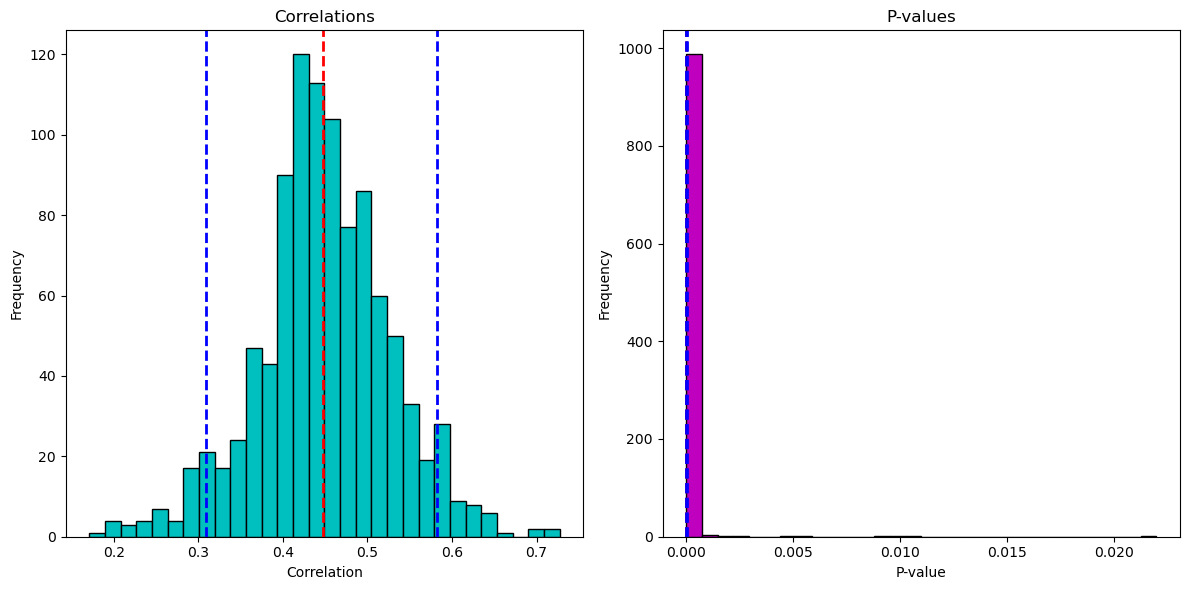

In [29]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Create a subplot for correlations
plt.subplot(1, 2, 1)
plt.hist(statistics, bins=30, color='c', edgecolor='black')
plt.axvline(statistics_median, color='r', linestyle='dashed', linewidth=2)
plt.axvline(statistics_5th, color='b', linestyle='dashed', linewidth=2)
plt.axvline(statistics_95th, color='b', linestyle='dashed', linewidth=2)
plt.title('Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

# Create a subplot for p-values
plt.subplot(1, 2, 2)
plt.hist(pvalues, bins=30, color='m', edgecolor='black')
plt.axvline(pvalues_median, color='r', linestyle='dashed', linewidth=2)
plt.axvline(pvalues_5th, color='b', linestyle='dashed', linewidth=2)
plt.axvline(pvalues_95th, color='b', linestyle='dashed', linewidth=2)
plt.title('P-values')
plt.xlabel('P-value')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()